In [1]:
%load_ext load_style
%load_style talk.css

# Process U-Wind: Zonal Mean and Interpolation

This notebook still works on u-Wind data. We will finish the following tasks
* calculate zonal mean
* interpolate zonal means along the axises of latitude and level

**Data**

wind data can be downlaed from https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.html

This u-wind is a 4D data, includding [months|levels|lat|lon]. The presure levels in hPa. 

Moreover, the wind data with **scaling** and **offset**. when using them, have to restore them to oringal values.

In addition, we will use the interpolation functions from another faumous library of SciPy, where scipy.interpolate.interp2d is used. See more from https://docs.scipy.org/doc/scipy/reference/interpolate.html.

## 1. Load basic libs

In [2]:
% matplotlib inline

from pylab import *
import numpy as np
from scipy.interpolate import interp2d

from netCDF4 import Dataset as netcdf # netcdf4-python module

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

## 2. Read u-wind data and pick variables

### 2.1 Use print to check variable information

Actually, you can also use numdump infile.nc -h to check the same inforamtion

In [3]:
ncset = netcdf(r'data/uwnd3.mon.mean.nc')
#print(ncset)

### 2.2 Read data

Have to set_auto_mask(False) to automatically scaling and offseting, or may cause problem.

In [4]:
ncset.set_auto_mask(False)

lon = ncset['lon'][:]  
lat = ncset['lat'][:] 
lev = ncset['level'][:]    
u   = ncset['uwnd'][504:624,:]   # for the period 1990-1999.

print(u.shape)

(120L, 17L, 73L, 144L)


In [5]:
print(lev)

[ 1000.   925.   850.   700.   600.   500.   400.   300.   250.   200.
   150.   100.    70.    50.    30.    20.    10.]


## 3. Calculate Mean in time

In [6]:
u_10y = np.mean(u, axis=0) # calculate mean for all years and months
u_10y.shape

(17L, 73L, 144L)

## 4. Calculate zonal mean

In [7]:
u_10y_zm = np.mean(u_10y, axis=2)
u_10y_zm.shape

(17L, 73L)

## 5. Visualize zonal mean

### 5.1 Extract first 10 levels from 1000 to 200 hPa

In [8]:
lev_10 = lev[0:10]
u_10y_zm_10 = u_10y_zm[0:10,:]

### 5.2 Visualize

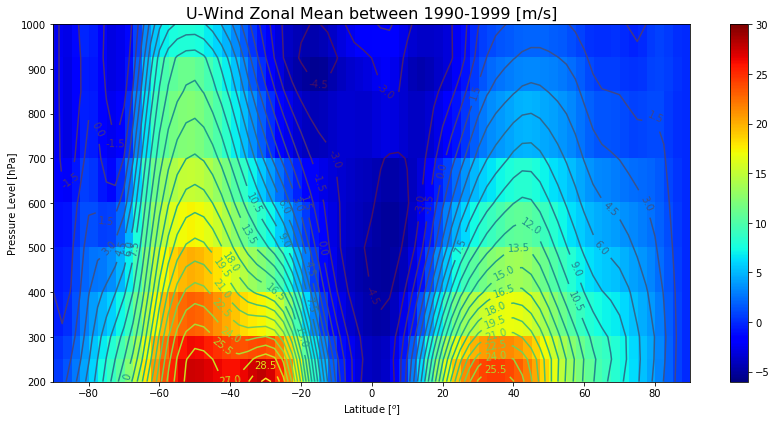

In [9]:
#minu = floor(np.min(u_10y_zm_10))
#maxu = ceil(np.max(u_10y_zm_10))
[lats, levs] = meshgrid(lat, lev_10)
fig, ax = plt.subplots()

im = ax.pcolormesh(lats, levs, u_10y_zm_10,  cmap='jet', vmin=-6., vmax=30.)
cf = ax.contour(lats, levs, u_10y_zm_10, 25, c='b',  vmin=-6., vmax=30.)

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%'
else:
    fmt = '%r'
ax.clabel(cf, inline=True, fmt=fmt, fontsize=10)

ax.set_title('U-Wind Zonal Mean between 1990-1999 [m/s]', fontsize=16)
ax.set_xlabel('Latitude [$^o$]')
ax.set_ylabel('Pressure Level [hPa]')

# set the limits of the plot to the limits of the data
ax.axis([lats.min(),lats.max(), levs.min(), levs.max()])

fig.colorbar(im)
fig.tight_layout()

## 6. Interpolate zonal mean from 10 to 41 levels

### 6.1 Make new grids

Create new levels between 1000 and 200

make resolution of latitude from 2.5 to 1.0
> It is worth noting to make level and latitude in a monotonic increasing manner.

In [10]:
lev_new = np.linspace(200,1000, num=41)
lat_new = np.linspace(-90, 90, num=181)

### 6.2 Begin to interpolate u_10y_zm_10 for new grids

In [11]:
func = interp2d(lat, lev_10, u_10y_zm_10, kind='cubic')
# apply to new level and latitude
unew = func(lat_new, lev_new)

### 6.3 Visualize the interpolated zonal mean

It should look better than orignal data.

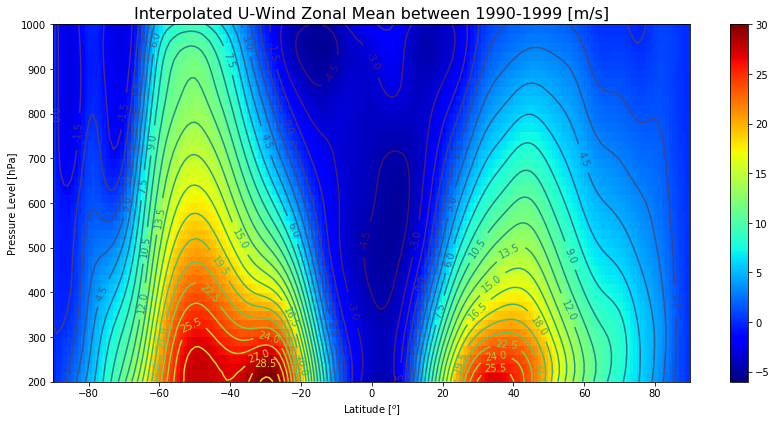

In [12]:
#minu = floor(np.min(unew))
#maxu = ceil(np.max(unew))
[lats, levs] = np.meshgrid(lat_new, lev_new)
fig, ax = plt.subplots()

im = ax.pcolormesh(lats, levs, unew, cmap='jet', vmin=-6., vmax=30.)
cf = ax.contour( lats, levs, unew, 25, c='b',  vmin=-6., vmax=30.)

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%'
else:
    fmt = '%r'
ax.clabel(cf, inline=True, fmt=fmt, fontsize=10)

ax.set_title('Interpolated U-Wind Zonal Mean between 1990-1999 [m/s]', fontsize=16)
ax.set_xlabel('Latitude [$^o$]')
ax.set_ylabel('Pressure Level [hPa]')

# set the limits of the plot to the limits of the data
ax.axis([lats.min(),lats.max(), levs.min(), levs.max()])

fig.colorbar(im)
fig.tight_layout()

## References

http://unidata.github.io/netcdf4-python/

Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470, 1996.

Matplotlib: A 2D Graphics Environment by J. D. Hunter In Computing in Science & Engineering, Vol. 9, No. 3. (2007), pp. 90-95

Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ [Online; accessed 2017-09-11]